In [35]:
# 1. Imports
import nltk
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

import joblib




nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meetv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meetv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\meetv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


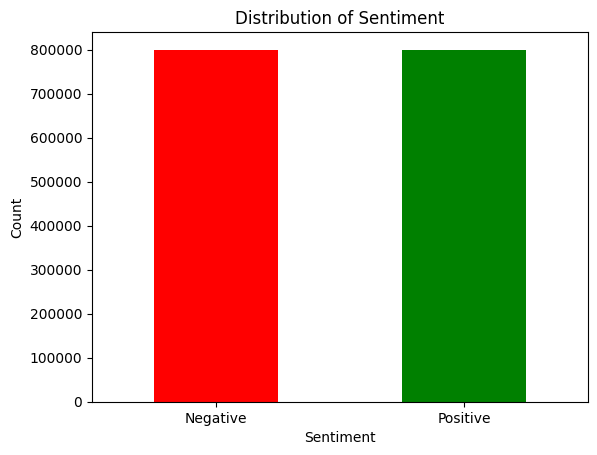

In [ ]:
# Load the sentiment140 dataset
df = pd.read_csv("A:\\V5C0D3\\Internship_Tasks\\Real-Time Twitter Senitment Analysis Dashboard\\dataset\\raw_data.csv", encoding='latin-1', header=None)
df = df[[0, 5]]  # Select only the relevant columns
df.columns = ["Sentiment", "Content"]  # Rename the selected columns
df['Sentiment'] = df['Sentiment'].apply(lambda x: 0 if x == 0 else 1)  # Binary classification: 0 (negative), 1 (positive)

# Optional: Shrink dataset to test faster
df = df.sample(1600000, random_state=42)

#Distribution of the dataset 
df['Sentiment'].value_counts().plot(kind='bar', color=['red', 'green']) 
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.show()


In [ ]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Step 1: Preprocess raw tweet text
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)         # remove punctuation
    text = re.sub(r"\d+", "", text)             # remove digits
    text = re.sub(r"\s+", " ", text).strip()    # normalize whitespace
    return text

# Convert sentiment labels: 0 = negative, 4 = positive → convert 4 to 1
df['label'] = df['Sentiment'].apply(lambda x: 0 if x == 0 else 1)

# Optional sanity check
df[['Content', 'label']].head()
# Add a new column for the cleaned and processed text
df['Processed_Content'] = df['Content'].apply(preprocess)

# Display the original and processed text for comparison
df[['Content', 'Processed_Content', 'label']].head()


,Content,Processed_Content,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboobs ahhh i hope your ok,0
750,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool i have no tweet apps for my...,0
766711,@TiannaChaos i know just family drama. its la...,tiannachaos i know just family drama its lameh...,0
285055,School email won't open and I have geography ...,school email wont open and i have geography st...,0
705995,upper airways problem,upper airways problem,0


In [ ]:
# Apply preprocessing before vectorizing
X = df['Processed_Content'] # Preprocessed text
y = df['label']

# Step 2: Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: TF-IDF with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

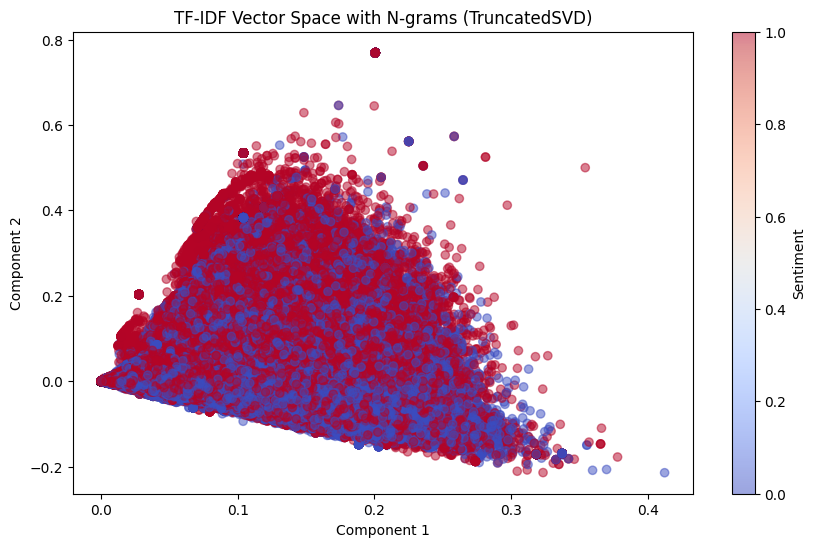

In [ ]:
# Reduce dimensions to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_2D = svd.fit_transform(X_train)

# Plot the 2D representation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("TF-IDF Vector Space with N-grams (TruncatedSVD)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Sentiment")
plt.show()

C:\Users\meetv\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


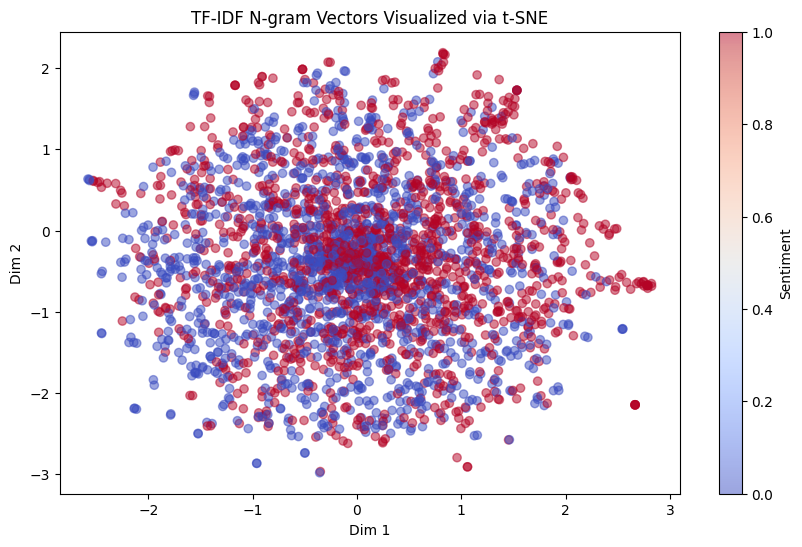

In [ ]:
# Note: Subset to ~3000 samples for faster t-SNE
X_subset = X_train[:3000]
y_subset = y_train[:3000]

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_subset.toarray())

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='coolwarm', alpha=0.5)
plt.title("TF-IDF N-gram Vectors Visualized via t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(scatter, label="Sentiment")
plt.show()


In [ ]:
# Initialize Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"🔹 Naive Bayes Accuracy: {accuracy_nb:.6f}\n")

print("🔹 Classification Report:")
print(classification_report(y_test, y_pred_nb))


🔹 Naive Bayes Accuracy: 0.781441

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78    159989
           1       0.79      0.77      0.78    160011

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [ ]:
nb_ng = MultinomialNB()
nb_ng.fit(X_train, y_train)
y_pred_nb_ng = nb_ng.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print(f"Naive Bayes with n-grams Accuracy: {accuracy_score(y_test, y_pred_nb_ng):.4f}")
print(classification_report(y_test, y_pred_nb_ng))


Naive Bayes with n-grams Accuracy: 0.7814
              precision    recall  f1-score   support

           0       0.77      0.79      0.78    159989
           1       0.79      0.77      0.78    160011

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8040
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159989
           1       0.79      0.82      0.81    160011

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [ ]:
results = {
    "Naive Bayes": accuracy_nb,
    "Naive Bayes + n-gram": accuracy_score(y_test, y_pred_nb_ng),
    "SVM": accuracy_score(y_test, y_pred_svm)
}

for model, acc in results.items():
    print(f"{model:25s}: {acc:.4f}")

Naive Bayes              : 0.7814
Naive Bayes + n-gram     : 0.7814
SVM                      : 0.8040


In [ ]:
# Save the model and vectorizer
joblib.dump(svm, 'model/linear_svc_model.pkl')
joblib.dump(vectorizer, 'model/tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']